

<h1>Projeto de Transfer Learning em Python</h1>

Este projeto explora o uso de aprendizado por transferência e ajuste fino para treinar classificadores de imagens com um número limitado de amostras. Utilizando o modelo VGG16 como base, a última camada é substituída para adaptar-se às novas classes. Comparado ao treinamento de uma rede do zero, o aprendizado por transferência demonstrou melhorias significativas na precisão do classificador, destacando sua eficácia e escalabilidade em conjuntos de dados menores.



# Passo 1
## Fazer a importação das Bibliotecas necessárias.


In [133]:
import os
from google.colab import drive
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model


# Passo 2
## Definir o diretório raiz e as proporções de treinamento e validação, e obter as categorias.

In [18]:
root = '/content/drive/My Drive/Dados'
train_split, val_split = 0.7, 0.15
categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['/content/drive/My Drive/Dados/dogs', '/content/drive/My Drive/Dados/cats']


# Passo 3

 ## Implementar uma função auxiliar para carregar imagens e preparar o vetor de entrada.


In [14]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

# Passo 4
## Coletar dados das imagens e preparar os vetores de entrada e os rótulos

In [15]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)


# Passo 5
## Embaralhar os dados coletados.

In [19]:
random.shuffle(data)

# Passo 6
## Dividir os dados em conjuntos de treinamento, validação e teste.

In [20]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]


# Passo 7
## Extrair os vetores de entrada (x) e os rótulos (y) dos conjuntos de treinamento, validação e teste.

In [21]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1]


# Passo 8
## Fazer a normalização e converter rótulos em vetores one-hot.

In [22]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(216, 2)


# Resumo dos dados carregados e suas dimensões

In [23]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 1436 images from 2 categories
train / validation / test split: 1005, 215, 216
training data shape:  (1005, 224, 224, 3)
training labels shape:  (1005, 2)


# Passo 9
## Carregar e visualizar um conjunto de 8 imagens aleatórias.

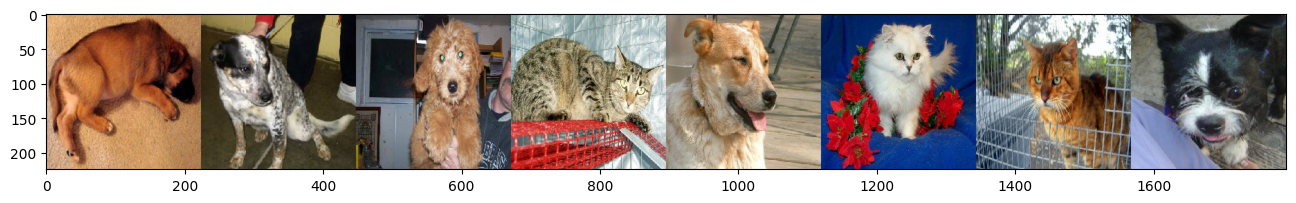

In [26]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

# Construindo a arquitetura da rede neural convolucional

In [31]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                

# Passo 10
## Compilar e treinar o modelo.

In [32]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
8/8 [==============================] - 95s 11s/step - loss: 0.7056 - accuracy: 0.5104 - val_loss: 0.6929 - val_accuracy: 0.5023
Epoch 2/10
8/8 [==============================] - 80s 10s/step - loss: 0.6722 - accuracy: 0.5771 - val_loss: 0.6885 - val_accuracy: 0.5023
Epoch 3/10
8/8 [==============================] - 79s 10s/step - loss: 0.6718 - accuracy: 0.5771 - val_loss: 0.6822 - val_accuracy: 0.5023
Epoch 4/10
8/8 [==============================] - 84s 11s/step - loss: 0.6578 - accuracy: 0.5771 - val_loss: 0.6711 - val_accuracy: 0.5163
Epoch 5/10
8/8 [==============================] - 79s 10s/step - loss: 0.6376 - accuracy: 0.5801 - val_loss: 0.6514 - val_accuracy: 0.5535
Epoch 6/10
8/8 [==============================] - 84s 11s/step - loss: 0.6311 - accuracy: 0.6149 - val_loss: 0.6425 - val_accuracy: 0.5535
Epoch 7/10
8/8 [==============================] - 80s 10s/step - loss: 0.6220 - accuracy: 0.6249 - val_loss: 0.6466 - val_accuracy: 0.5535
Epoch 8/10
8/8 [===========

# Visualizando a perda e a acurácia de validação ao longo das épocas

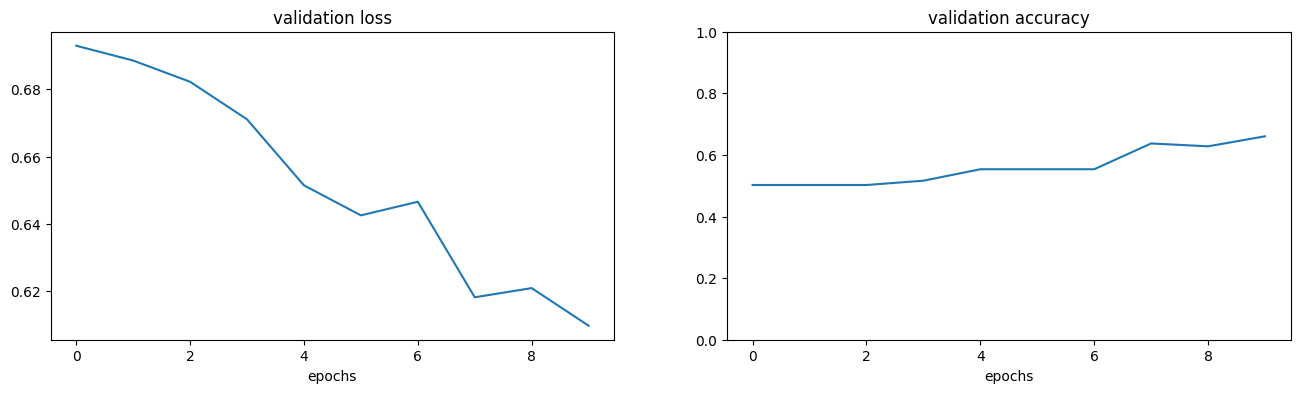

In [34]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

# Passo 11
## Imprimir os resultados.

In [35]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6071346998214722
Test accuracy: 0.6342592835426331


# Passo 12
## Carregar e visualizar a arquitetura do modelo VGG16 pré-treinado.

In [36]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

# Passo 13
## Adaptar a arquitetura do modelo VGG16 para corresponder ao número de classes do novo conjunto de dados

In [37]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


# Passo 14
## Congelar todos os pesos das camadas (exceto a última) e compilar o novo modelo

In [38]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Treinando o novo Modelo

In [39]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))

Epoch 1/10
8/8 [==============================] - 792s 101s/step - loss: 1.0067 - accuracy: 0.5244 - val_loss: 0.7592 - val_accuracy: 0.5163
Epoch 2/10
8/8 [==============================] - 846s 108s/step - loss: 0.7369 - accuracy: 0.5453 - val_loss: 0.6036 - val_accuracy: 0.5674
Epoch 3/10
8/8 [==============================] - 784s 100s/step - loss: 0.5965 - accuracy: 0.6408 - val_loss: 0.7130 - val_accuracy: 0.5023
Epoch 4/10
8/8 [==============================] - 779s 100s/step - loss: 0.5102 - accuracy: 0.7224 - val_loss: 0.4812 - val_accuracy: 0.8140
Epoch 5/10
8/8 [==============================] - 772s 99s/step - loss: 0.4576 - accuracy: 0.7881 - val_loss: 0.4647 - val_accuracy: 0.7814
Epoch 6/10
8/8 [==============================] - 762s 98s/step - loss: 0.4285 - accuracy: 0.8010 - val_loss: 0.4406 - val_accuracy: 0.8419
Epoch 7/10
8/8 [==============================] - 759s 97s/step - loss: 0.3892 - accuracy: 0.8557 - val_loss: 0.4209 - val_accuracy: 0.8419
Epoch 8/10
8/8 [

# Visualizando a perda e a acurácia de validação ao longo das épocas e comparando os modelos

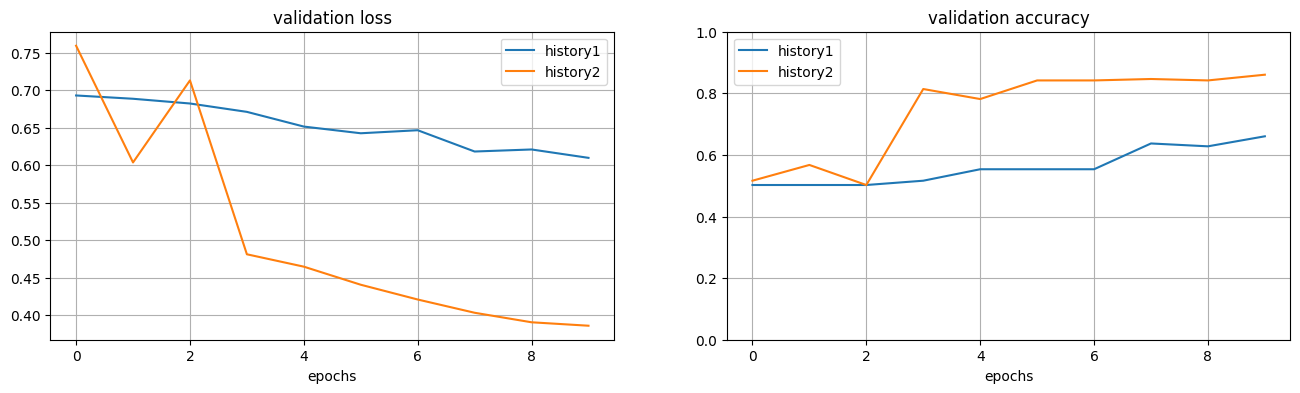

In [45]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"], label='history1')
ax.plot(history2.history["val_loss"], label='history2')
ax.set_title("validation loss")
ax.set_xlabel("epochs")
ax.legend()  # Adicionando legenda
ax.grid(True)

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"], label='history1')
ax2.plot(history2.history["val_accuracy"], label='history2')
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)
ax2.legend()  # Adicionando legenda
ax2.grid(True)

plt.show()

# Imprimindo os Resultados

In [46]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.33403468132019043
Test accuracy: 0.8935185074806213



# Passo 15
## Usar o modelo adaptado para prever a classe de uma imagem de teste específica.

In [134]:
img, x = get_image('/content/drive/My Drive/imagemteste1.jpg')
probabilities = model_new.predict([x])
print(probabilities)

1/1 [==============================] - 1s 645ms/step
[[1.000000e+00 9.312606e-15]]


# Passo 16
## Criar uma função para prever a classe de uma imagem usando o modelo adaptado.

In [135]:
def predict_animal(image_path, model):
    img, x = get_image(image_path)
    probabilities = model.predict([x])[0]

    # Interpretando a saída
    if probabilities[0] > 0.5:  # Defina um limiar adequado
        prediction = 'Cachorro'
        probability = probabilities[0]
    else:
        prediction = 'Gato'
        probability = probabilities[1]

    return prediction, probability

# Visualizando o Resultado

1/1 [==============================] - 1s 1s/step
Previsão: Cachorro - Probabilidade: 1.0000


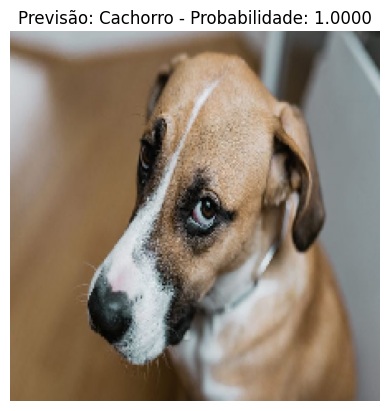

In [136]:

image_path = '/content/drive/My Drive/imagemteste1.jpg'
prediction, probability = predict_animal(image_path, model_new)
print(f'Previsão: {prediction} - Probabilidade: {probability:.4f}')

plt.imshow(img)
plt.axis('off')
plt.title(f'Previsão: {prediction} - Probabilidade: {probability:.4f}')
plt.show()
